In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import itertools
import os

## Generalized Scheme

In [7]:
def generate_pauli_gate_set(pauli_type: str, d: int) -> list[QuantumCircuit]:
    if (d & (d - 1)) != 0:
        raise ValueError("Dimension d must be a power of 2")
    n = int(np.log2(d))
    gate_set = []
    
    for bits in itertools.product([0, 1], repeat=n):
        qc = QuantumCircuit(n)
        for qubit, apply_gate in enumerate(bits):
            if apply_gate:
                if pauli_type.upper() == 'X':
                    qc.x(qubit)
                elif pauli_type.upper() == 'Z':
                    qc.z(qubit)
        qc.name = f"{pauli_type.upper()}{int(''.join(map(str, bits)), 2)}"
        gate_set.append(qc)
    return gate_set

def Super_Dense_Coding(d, D, z, x):
    if (not(((d & (d - 1)) == 0)) or not(((D & (D - 1)) == 0)) or d > D):
        raise ValueError("Recheck your dimensions.")

    length_d = int(np.log2(d))
    length_D = int(np.log2(D))

    if x >= D or z >= d:
        raise ValueError("Recheck your indices x and z.")

    qc = QuantumCircuit(length_d + length_D)


    for i in range(length_d):
        qc.h(i)
        qc.cx(i, length_D + i)

    qc.barrier(label='Entanglement')

    z_gates = generate_pauli_gate_set('Z', d) 
    x_gates = generate_pauli_gate_set('X', D) 

    qc.append(z_gates[z].to_instruction(), list(range(length_d)))
    qc.append(x_gates[x].to_instruction(), list(range(length_D)))

    qc.barrier(label='Encoding')

    for i in range(length_d - 1, -1, -1):
        qc.cx(i, length_D + i)
        qc.h(i)
    qc.measure_all()
    return qc

## Test Circuit

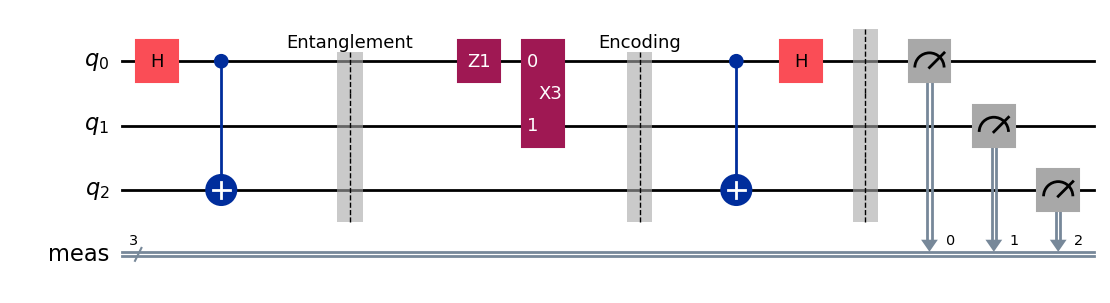

C:\Users\hussa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


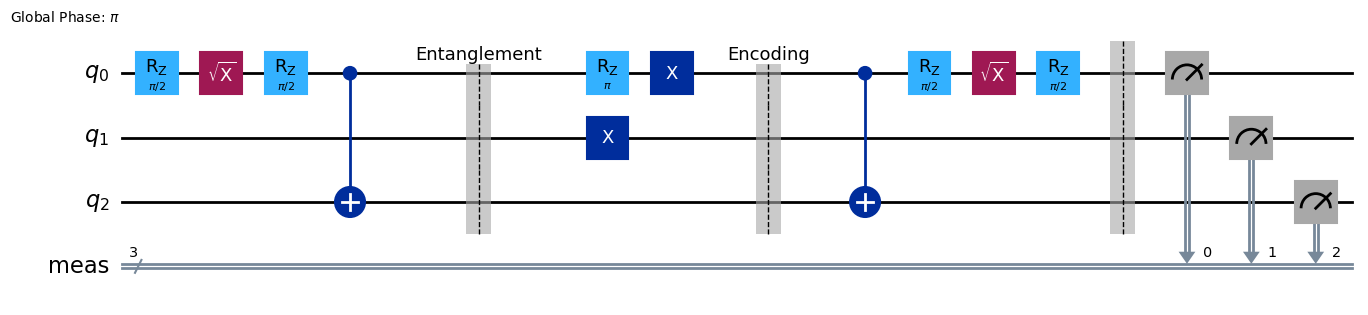

Measurement Counts: {'111': 10000}


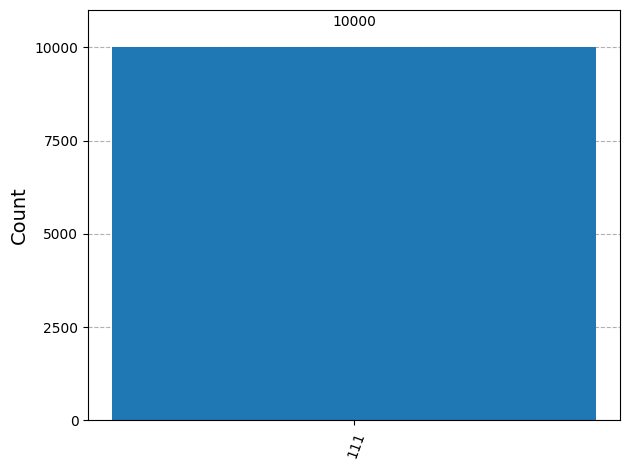

In [8]:
qc = Super_Dense_Coding(2,4,1,3)           #Generated Cirucit (entaglment dimension, embbeded dimension, Z-gate, X-gate)

display(qc.draw('mpl'))
sim3 = AerSimulator()
tqc = transpile(qc, sim3, basis_gates=['rz', 'sx', 'x', 'cx'],optimization_level=3) # Optimization level can help reduce depth
display(tqc.draw('mpl'))
result3 = sim3.run(tqc, shots=10000).result()
counts3 = result3.get_counts()

# Show results 
print("Measurement Counts:", counts3)
plot_histogram(counts3)

## Test on Hardware

In [9]:
D_list = []
d_list = []
succes_prob_list = []
gates_list = []
your_api_key = os.getenv("API_KEY_IBM")  #API Key Here
your_crn = os.getenv("CRN_IMB")          #CRN Here

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
import pandas as pd

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    name="qgss-2025",
    overwrite=True
    )

for p in range(1, 6):                  #Entanglment limit
    d = 2**p
    for i in range(p, 11-p):          #Embbeded Dimension limit
        D = 2**i

        qc = Super_Dense_Coding(d,D,d-1, D-1)
        tqc = transpile(qc, sim3, basis_gates=['rz', 'sx', 'x', 'cx'],optimization_level=3)


        gates_list.append(tqc.count_ops())
        D_list.append(D)
        d_list.append(d)
        
        service = QiskitRuntimeService(name="qgss-2025")
        service.saved_accounts()
        # Get a backend
        backend = service.least_busy(operational=True, simulator=False)
        print(f"We are using the {backend.name} quantum computer ")
        print(str(d) + "x" + str(D))

        service = QiskitRuntimeService(name="qgss-2025")

        sampler = Sampler(mode=backend)

        pm = generate_preset_pass_manager(backend=backend, optimization_level=3)


        job = sampler.run(pm.run([qc]), shots=10000)

        results_sampler = job.result()
        counts =results_sampler[0].data.meas.get_counts()
        
        max_val = max(counts.values())
        succes_prob_list.append(max_val/100)


print(gates_list)
print(d_list)
print(D_list)
print(np.log2(np.array(d_list)*np.array(D_list)))
print(succes_prob_list)


KeyboardInterrupt: 